### Integration of SVM and MVO 
3 factor, 3 turnover, premium of 10% experiments

This notebook only contains exact solves

In [1]:
import gurobipy as gp
from gurobipy import GRB
pth = ''
import sys
import math
import time

from python.packages import *
from python.svm_mvo import *
from python.analysis_tools import *
from itertools import product
import os

%matplotlib inline
## Import Forecasts
forecasts = pd.read_pickle(pth +'cache/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'cache/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'cache/WRDS_ASOF.pkl')
## Import monthly prices
prices = pd.read_pickle(pth + 'cache/PRICES.pkl')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-03


In [15]:
mth = rets.index[6]
start_mth = mth + pd.DateOffset(months=1)
start_mth

Timestamp('2001-02-01 00:00:00')

In [16]:
#convenient function
sign = lambda a: int((a>0)) - int((a<0))

#preprocessing
cov_, mean_ = forecasts[mth]
N = len(mean_)
cov = cov_[:N,:N]
mean = mean_[:N,:]
tics = list(rets.columns[:N])
print("valid tickers:", tics)

#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")

#restrict the wharton research data to the columns of interest
#Y = wrds_tics.loc[:,"ROC1":"Vol"] # Y matrix in formulation as per the paper
cols = ['Vol']
Y = wrds_tics.loc[:,cols] # Y matrix in formulation

# def vol_data_treatment(Y):
#     Y_ = (Y.rank(axis = 0)/(len(Y))+1)
#     Y_.Vol = -1*Y_.Vol #for Vol Limit
#     return Y_
#
def vol_data_treatment(Y):
    Y.Vol = -1*(Y.Vol)/Y.Vol.std(axis=0) #for Vol Limit
    return Y

Y = vol_data_treatment(Y)

# def vol_data_treatment(Y):
#     Y.Vol = Y.Vol
#     Y_ = -1*(Y.rank(axis = 0)/(len(Y))+1)
#     #Y_ =  (Y_ - Y_.mean(axis=0))/(Y_.std(axis=0)) #scale the features
#     # #for Vol Limit
#     return Y_

#Y = vol_data_treatment(Y)

ret_constr = 0.01 #no return constraint
soft_margin = 1000 #large preference for separation feasibility

ratio = 0.1 #% of assets
card_desc = "Card03"

AssetLim = math.floor(N*ratio)
epsilon = 1e-3 #epsilon hyper-parameter
non_negativity_setting = True #set the hyperplane to have a normal in the non-negative orthant
            #SVM Heavy to not heavy

dpi_setting = 150

valid tickers: ['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO', 'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX', 'BWA', 'CAG', 'CAH', 'CAT', 'CCI', 'CCL', 'CDNS', 'CERN', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMCSA', 'CMI', 'CMS', 'CNP', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'CVS', 'CVX', 'D', 'DD', 'DGX', 'DHR', 'DIS', 'DISH', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'ES', 'ETN', 'ETR', 'EVRG', 'EXC', 'EXPD', 'F', 'FAST', 'FCX', 'FDX', 'FE', 'FFIV', 'FISV', 'FLS', 'FMC', 'GD', 'GIS', 'GLW', 'GPC', 'GPS', 'GWW', 'HAL', 'HAS', 'HD', 'HES', 'HFC', 'HOG', 'HOLX', 'HON', 'HP', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HSY', 'HUM', 'IBM', 'IDXX', 'IEX', 'IFF', 'INCY', 'INTC', 'INTU', 'IP', 'IPG', 'IRM', 

In [17]:
def callback_show_iterates(instance):

    k = instance.k
    Y = rank_normalize(instance.SVM_.exogenous)
    SVM_ = instance.SVM_

    MVO_ = instance.MVO_

    assert len(Y.shape) == 1 or Y.shape[1] == 1

    # fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
    # fig.suptitle('Iteration '+str(k))

    df1 = pd.DataFrame({"Volatility":Y.flatten(),
                       "Nothing just look at Volatility":np.zeros(len(Y)),
                       "$z \in \{0,1\}$":MVO_.z.x})
    df1['Sub-problem'] = 'CCPO'

    predicted_signs = np.array([0.5 + 0.5*sign(a[0]) for a in SVM_.decision_boundary])

    df2 = pd.DataFrame({"Volatility":Y.flatten(),
                       "Nothing just look at Volatility":np.zeros(len(Y)),
                       "$z \in \{0,1\}$":predicted_signs})

    df2['Sub-problem'] = 'SVM'

    df = pd.concat([df1, df2], axis = 0)

    sns.lmplot(data=df, x="Volatility", y="Nothing just look at Volatility", hue="$z \in \{0,1\}$", fit_reg=False, col= "Sub-problem", height=3)


In [18]:
MVO_ = MVO(tics, mean, cov, ret_constr, AssetLim, epsilon=epsilon)
SVM_ = SVM(tics, Y , soft_margin, non_neg = non_negativity_setting, epsilon=epsilon)

In [19]:
import seaborn as sns
MVO_.decision_boundary = None
MVO_.model.params.MIPGap = 0.05
MVO_.set_model()
MVO_.optimize()
SVM_.mvo_z = MVO_.z.x
SVM_.class_weights = get_mvo_class_weights(MVO_.z.x)
SVM_.set_model()
SVM_.optimize()
np.array([i[0] for i in SVM_.decision_boundary])
np.array([i[0] for i in SVM_.decision_boundary])

Set parameter MIPGap to value 0.05
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 290 rows, 1716 columns and 1716 nonzeros
Model fingerprint: 0x63424524
Model has 41041 quadratic objective terms
Variable types: 1430 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 3e+01]
Found heuristic solution: objective 0.0144533
Presolve removed 1 rows and 1144 columns
Presolve time: 0.01s
Presolved: 289 rows, 572 columns, 1430 nonzeros
Presolved model has 41041 quadratic objective terms
Variable types: 286 continuous, 286 integer (286 binary)

Root relaxation: objective 5.854516e-04, 217 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  

array([-1.62607023e-03,  1.75437785e-04, -1.42506985e-03,  8.49844785e-04,
       -1.35002708e-03, -1.60034696e-03,  8.91983103e-04,  1.03355513e-03,
        1.30326350e-04,  1.14082163e-03,  1.02728419e-03,  3.72274989e-04,
        7.23238975e-04, -3.17742052e-03,  6.15117968e-04,  5.19697769e-04,
       -8.08844589e-04, -3.95179762e-04,  9.31205896e-04,  2.22380637e-04,
       -1.56347292e-04, -1.20701606e-03,  6.48123415e-04,  4.30498333e-04,
        9.33549696e-04,  2.67144292e-04,  8.30103803e-04, -4.13860815e-04,
        8.02492015e-04,  8.83896416e-04,  8.87668121e-04,  7.37481556e-04,
        9.54006561e-04, -2.44338308e-03,  6.62387748e-04, -2.72900442e-03,
        8.77384576e-04,  7.94562637e-04,  6.22227256e-04,  8.89231679e-04,
        9.85960087e-04,  8.90525727e-04,  7.56796094e-04, -1.08318535e-03,
       -1.45567311e-04,  1.08947103e-04, -9.25161584e-04,  8.13575024e-04,
        3.22927844e-04,  8.81195335e-04,  7.39371951e-04,  4.89152914e-04,
        5.04476853e-04,  

<AxesSubplot:xlabel='Asset'>

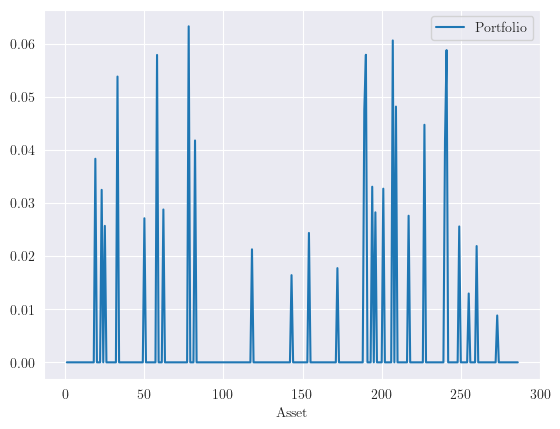

In [20]:
df = pd.DataFrame({"Asset":np.arange(N)+1, "Portfolio":MVO_.x.x})
df.plot(x = 'Asset', y = "Portfolio")

In [21]:
Y.loc[Y.values > 2]

,Vol
tic,


In [22]:
def rank_normalize(Z):
    if type(Z) == np.ndarray:
        Z = pd.Series(Z)
    Y = Z.rank(axis = 0)/(len(Z)+1)
    return Y.values

# def rank_normalize(Z):
#     if type(Z) == np.ndarray:
#         Z = pd.Series(Z)
#     return Z.values

Asset i 0
asset sign  -1.0
hyperplane  [0.00177479]
bias   [0.00131753]
Vol   Vol   -1.658561
Name: AAPL, dtype: float64
decision boundary asset  0  value  [-0.00162607]
predicted sign  -1
slack  0  value  6.637494407338117e-13
Asset i 1
asset sign  -1.0
hyperplane  [0.00177479]
bias   [0.00131753]
Vol   Vol   -0.643509
Name: ABC, dtype: float64
decision boundary asset  1  value  [0.00017544]
predicted sign  1
slack  1  value  0.0011754377857097918
Asset i 2
asset sign  -1.0
hyperplane  [0.00177479]
bias   [0.00131753]
Vol   Vol   -1.545308
Name: ABMD, dtype: float64
decision boundary asset  2  value  [-0.00142507]
predicted sign  -1
slack  2  value  6.630393497463649e-13
Asset i 3
asset sign  -1.0
hyperplane  [0.00177479]
bias   [0.00131753]
Vol   Vol   -0.263517
Name: ABT, dtype: float64
decision boundary asset  3  value  [0.00084984]
predicted sign  1
slack  3  value  0.0018498447853286081
Asset i 4
asset sign  -1.0
hyperplane  [0.00177479]
bias   [0.00131753]
Vol   Vol   -1.503026


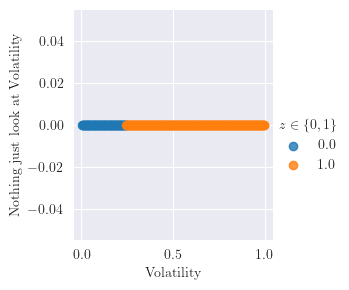

In [23]:
n, m = Y.shape
predicted_signs = []
for i in range(n):
    a = SVM_.decision_boundary[i]
    #if int(sign(a[0])) != int(2 * MVO_.z[i].x - 1):
    print("Asset i", i)
    # self.model.addConstr((-1) * self.epsilon + self.xi[i] + big_m * self.z[i] >= a, "svm1")
    # self.model.addConstr(-1 * big_m * (1 - self.z[i]) + 1 * self.epsilon - self.xi[i] - a <= 0, "svm2")
    #print(2 * a[0] * MVO_.z[i].x - a[0])
    print("asset sign ", 2 * MVO_.z[i].x - 1)
    print("hyperplane ", SVM_.w.x)
    print("bias  ", SVM_.b.x)
    print("Vol  ", Y.iloc[i])
    print("decision boundary asset ", i, " value ", a)
    print("predicted sign ", sign(a[0]))
    predicted_signs.append(sign(a[0]))
    print("slack ", i, " value ", SVM_.xi[i].x)
idx = Y.values.flatten() < 4

predicted_signs = [sign(a[0]) for a in SVM_.decision_boundary]
df = pd.DataFrame({"Volatility":rank_normalize(Y.values.flatten()),
                   "Nothing just look at Volatility":np.zeros(len(Y.values)),
                   "$z \in \{0,1\}$":0.5+ 0.5*np.array(predicted_signs)})
sns.lmplot(data=df, x="Volatility",
           y="Nothing just look at Volatility",
           hue="$z \in \{0,1\}$",
           fit_reg=False, height = 3)

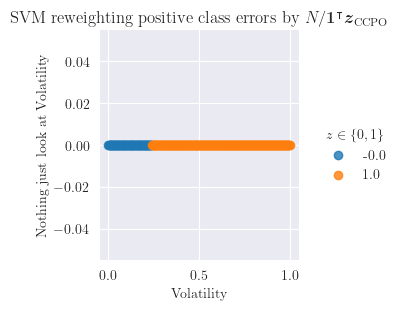

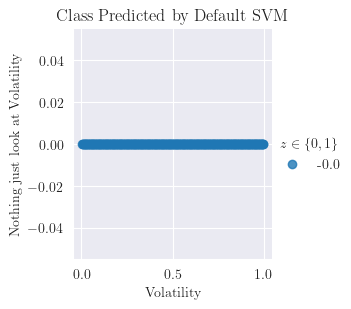

In [24]:
from sklearn.svm import SVC

class_weight = {0: len(MVO_.z.x)/(len(MVO_.z.x) - MVO_.z.x.sum()), 1: len(MVO_.z.x)/MVO_.z.x.sum()}

def test_svm(idx, MVO_, Y, class_weight, title = ''):
    svm = SVC(kernel = 'linear', C = 1000, class_weight=class_weight)
    svm.fit(Y.values, MVO_.z.x)
    svm.predict(Y.values)

    df = pd.DataFrame({"Volatility":rank_normalize(Y.values[idx].flatten()),
                       "Nothing just look at Volatility":np.zeros(len(Y.values[idx])),
                       "$z \in \{0,1\}$":np.array(svm.predict(Y.values[idx]))})
    sns.lmplot(data=df, x="Volatility", y="Nothing just look at Volatility", hue="$z \in \{0,1\}$", fit_reg=False, height = 3)
    plt.title(title)

test_svm(idx, MVO_, Y, class_weight, r'SVM reweighting positive class errors by $N/\boldsymbol{1}^{\intercal} \boldsymbol{z}_{\text{CCPO}}$ ')

test_svm(idx, MVO_, Y, {0:1,1:1}, r'Class Predicted by Default SVM')

Text(0.5, 1.0, 'Assets Selected by Cardinality Constrained Portfolio Selection')

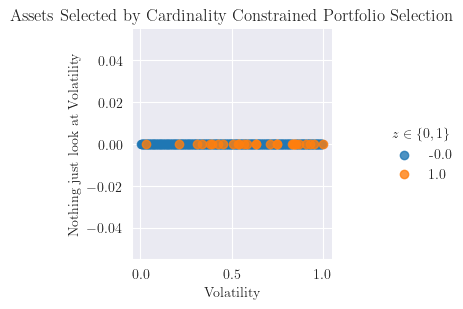

In [25]:
df = pd.DataFrame({"Volatility":rank_normalize(Y.values[idx].flatten()),"Nothing just look at Volatility":np.zeros(len(Y.values[idx])), "$z \in \{0,1\}$":MVO_.z.x[idx]})
sns.lmplot(data=df, x="Volatility", y="Nothing just look at Volatility", hue="$z \in \{0,1\}$", fit_reg=False,height=3)
plt.title("Assets Selected by Cardinality Constrained Portfolio Selection")

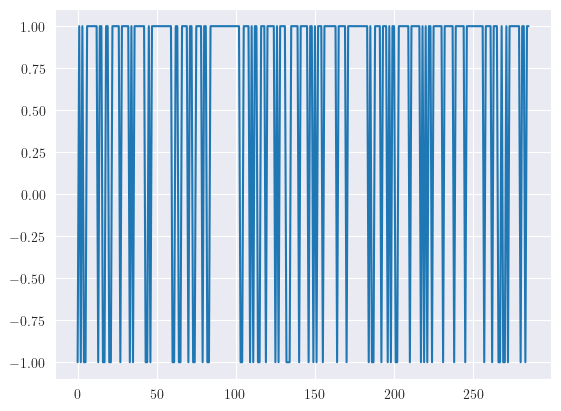

In [26]:
plt.plot(predicted_signs)

Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 60
Initialization successful
Solution time 76.18221020698547


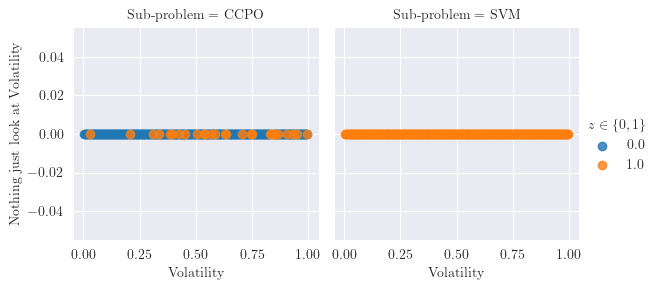

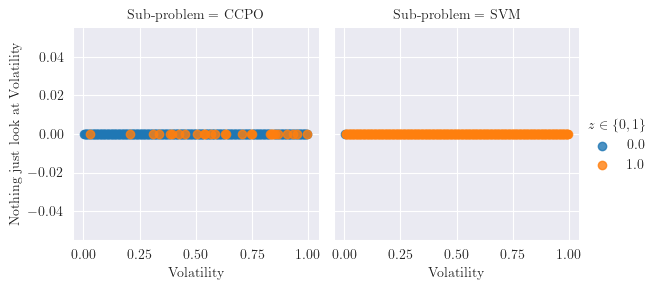

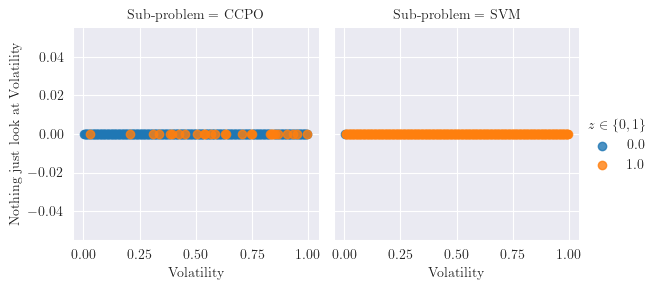

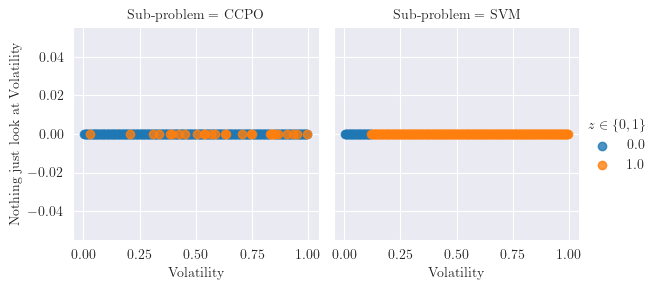

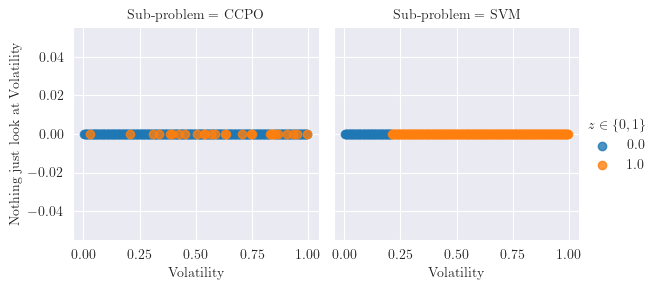

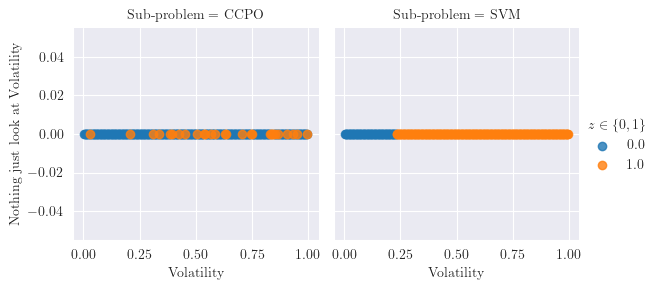

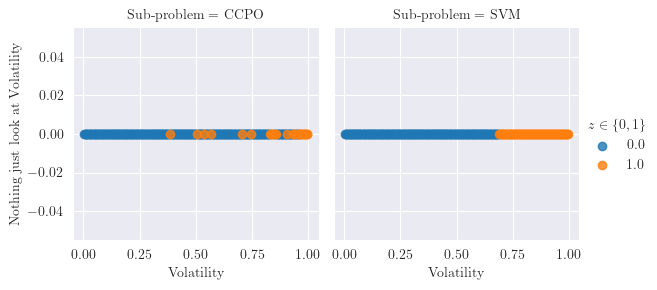

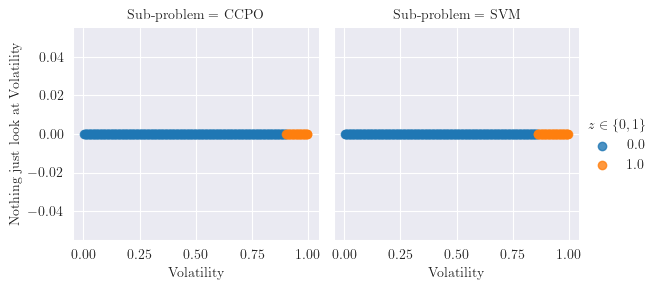

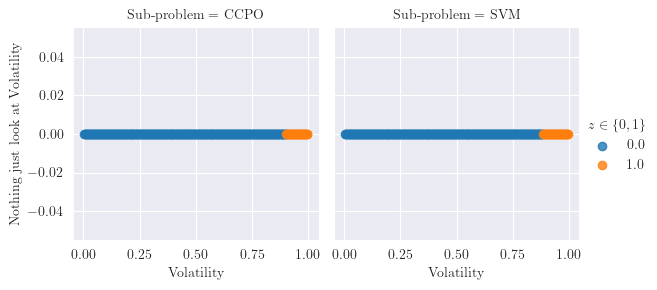

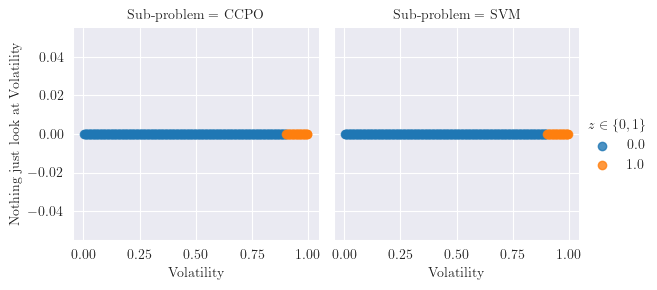

In [27]:
SVM_MVO_Fast = SVM_MVO_ADM(MVO_, SVM_, IterLim = 3, ParamLim = 10, class_weighted = True)
SVM_MVO_Fast.MVO_.model.params.MIPGap = 0.05
SVM_MVO_Fast.MVO_.model.params.timelimit = 10
SVM_MVO_Fast.SVM_.model.params.timelimit = 60
SVM_MVO_Fast.MVO_.model.params.OutputFlag = 0
SVM_MVO_Fast.SVM_.model.params.OutputFlag = 0
SVM_MVO_Fast.track_change = False #determine global convergence if z has changed by more than 20%
SVM_MVO_Fast.change_threshold = 0.5 #if z has changed by twenty percent or more then we have achieved convergence
start = time.time()
SVM_MVO_Fast.silence_output()
SVM_MVO_Fast.initialize_soln()
print("Initialization successful")
ws , xs, zs , xi_mvo, xi_svm, dt, objs_svm, objs_mvo, penalty_hist = SVM_MVO_Fast.solve_adm(callbacks = [callback_show_iterates])
end = time.time()
print("Solution time", end - start)

In [28]:
MVO2 = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y, AssetLim, non_neg = non_negativity_setting,\
             svm_choice = (True, False), print_var_frntr= False, cardinality = True) #define an instance of the class
MVO2.set_model() #set up the model
MVO2.optimize() #find optimal solution
MVO2.model.params.outputflag = 0

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 862 rows, 860 columns and 3432 nonzeros
Model fingerprint: 0xa4e62362
Model has 41042 quadratic objective terms
Variable types: 574 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+02]
Presolve removed 1 rows and 286 columns
Presolve time: 0.02s
Presolved: 861 rows, 574 columns, 3146 nonzeros
Presolved model has 41042 quadratic objective terms
Variable types: 288 continuous, 286 integer (286 binary)

Root relaxation: objective 5.854516e-04, 670 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.0005

In [29]:
(xs > 0.001).any(axis = 0)

array([False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False, False,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
        True, False, False,  True,  True, False, False, False, False,
       False, False, False,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,

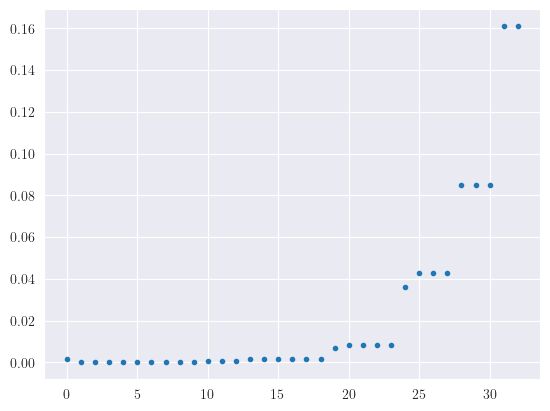

In [30]:
plt.plot(ws, '.')

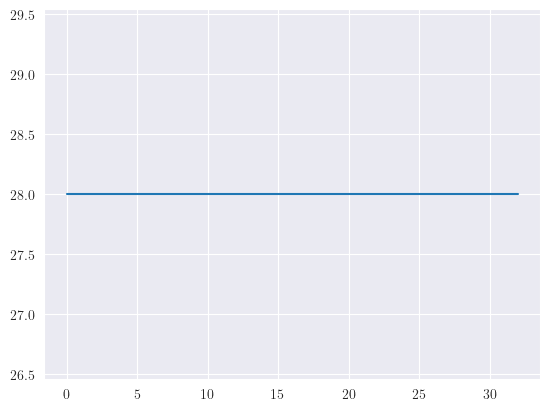

In [31]:
plt.plot(zs.sum(axis = 1))

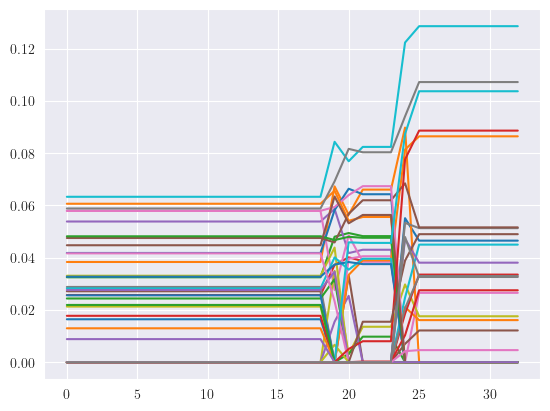

In [32]:
plt.plot(xs[:,(xs > 0.001).any(axis = 0)])

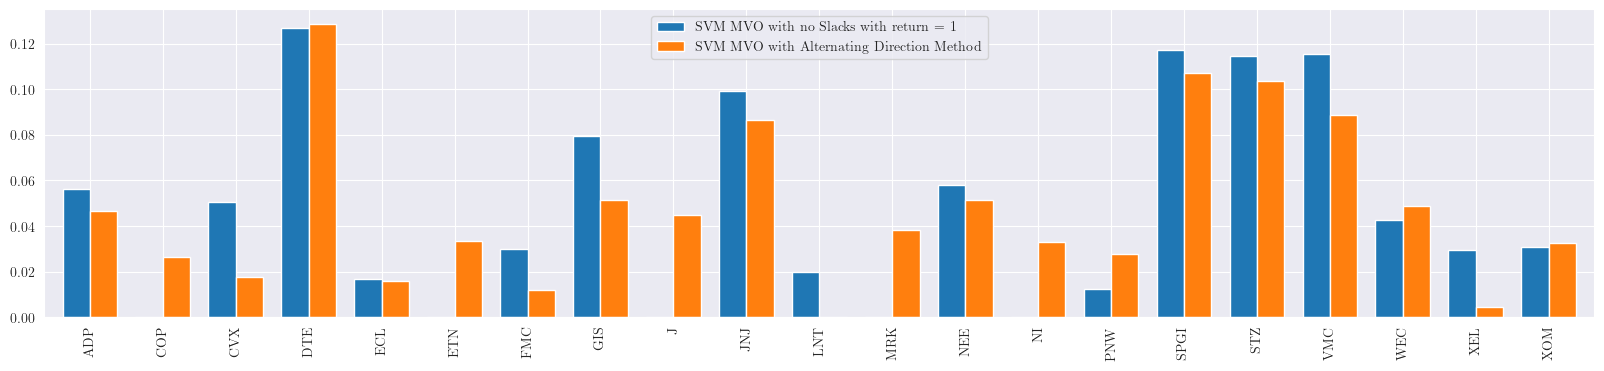

In [33]:
# plt.plot(MVO2.x.x)
# plt.plot(SVM_MVO_Fast.x.x)
#plt.plot(xs[0,:])
out = pd.concat([MVO2.get_results(), SVM_MVO_Fast.get_results()], axis = 0)
out[out.columns[(out > 0.001).any(axis = 0)]].transpose()[:-2].plot.bar(figsize = (20,4), width = 0.75);

In [34]:
MVO2.b.x

array([0.02695546])

In [35]:
SVM_MVO_Fast.b.x

array([0.02983653])

In [36]:
SVM_MVO_Fast.w.x

array([0.16100445])

In [37]:
MVO_.xi.x.sum()

0.003312011955470434

In [38]:
(epsilon - SVM_MVO_Fast.b.x)/SVM_MVO_Fast.w.x

array([-0.17910393])

In [39]:
MVO2.b.x/MVO2.w.x

array([0.1698399])

In [40]:
# # plt.plot(SVM_MVO_Slck.w.x, label = 'Slack')
# plt.plot(SVM_MVO_Fast.w.x, label= 'ADM')
# plt.legend();
#
# plt.figure()
# #plt.plot(SVM_MVO_Slck.xi.x, label = 'Slack')
# plt.plot(SVM_MVO_Fast.xi_mvo.x, label= 'ADM')
# plt.legend();

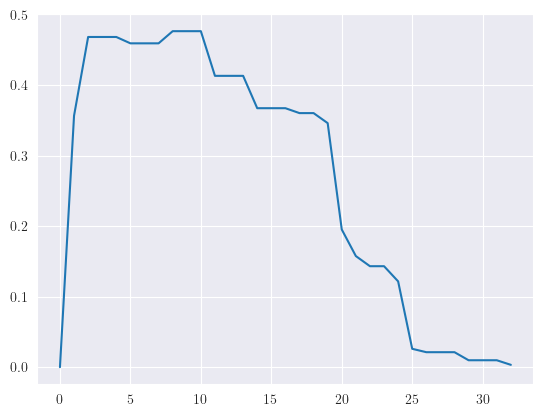

In [41]:
plt.plot(xi_mvo.sum(axis = 1))

array([0.3564003 , 0.49854487, 0.49854487, 0.49854487, 0.46248634,
       0.46248634, 0.46248634, 0.4763081 , 0.4763081 , 0.4763081 ,
       0.41318362, 0.41318362, 0.41318362, 0.36711573, 0.36711573,
       0.36711573, 0.36014577, 0.36014577, 0.36014577, 0.20377651,
       0.15966103, 0.1431357 , 0.1431357 , 0.1431357 , 0.02882101,
       0.02124251, 0.02124251, 0.02124251, 0.00982623, 0.00982623,
       0.00982623, 0.00331201, 0.00331201])

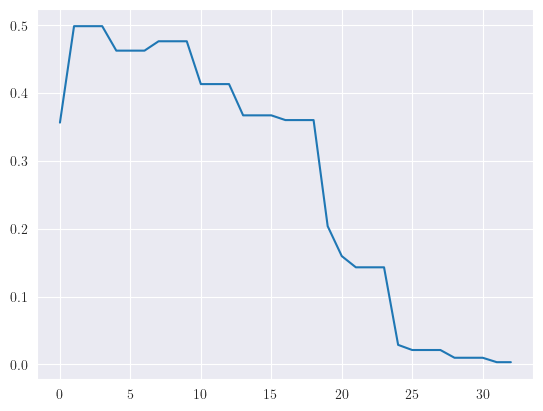

In [42]:
plt.plot(xi_svm.sum(axis = 1))
xi_svm.sum(axis = 1)

In [43]:
return_premium = 0.1 #similiar to Costa and Kwon 
#Limit = 0.75/6 #1/6 because Costa and Kwon use 1 for 6 month period. 
T = len(rets.index)

In [44]:
"".join(map(str, cols))

'Vol'